In [1]:
!pip -q install face_recognition

In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

IMG_DIR = 'img_celeba'  # Папка с оригинальными фото (Wild)
SAVE_DIR = 'celeba_cropped_10k'
ALIGNED_DIR = 'celeba_aligned'

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn3(self.conv3(self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))))) + self.skip(x))

class Hourglass(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.up = ResidualBlock(channels, channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.low = Hourglass(depth - 1, channels) if depth > 1 else ResidualBlock(channels, channels)
        self.low_post = ResidualBlock(channels, channels)
        self.up_sample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        return self.up(x) + self.up_sample(self.low_post(self.low(self.pool(x))))

class StackedHourglass(nn.Module):
    def __init__(self, num_stacks=2, num_pts=5, channels=128):
        super().__init__()
        self.num_stacks = num_stacks
        self.pre = nn.Sequential(nn.Conv2d(3, 64, 7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(True),
                                 ResidualBlock(64, 128), nn.MaxPool2d(2, 2), ResidualBlock(128, channels))
        self.hgs = nn.ModuleList([Hourglass(4, channels) for _ in range(num_stacks)])
        self.features = nn.ModuleList([nn.Sequential(ResidualBlock(channels, channels), nn.Conv2d(channels, channels, 1),
                                                    nn.BatchNorm2d(channels), nn.ReLU(True)) for _ in range(num_stacks)])
        self.outs = nn.ModuleList([nn.Conv2d(channels, num_pts, 1) for _ in range(num_stacks)])
        self.merge_preds = nn.ModuleList([nn.Conv2d(num_pts, channels, 1) for _ in range(num_stacks-1)])
        self.merge_feats = nn.ModuleList([nn.Conv2d(channels, channels, 1) for _ in range(num_stacks-1)])

    def forward(self, x):
        x = self.pre(x)
        outputs = []
        for i in range(self.num_stacks):
            hg = self.hgs[i](x)
            feature = self.features[i](hg)
            preds = self.outs[i](feature)
            outputs.append(preds)
            if i < self.num_stacks - 1:
                x = x + self.merge_feats[i](feature) + self.merge_preds[i](preds)
        return outputs

In [4]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class FaceNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        self.in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # Убираем стандартный классификатор
        
        # Слой эмбеддингов (промежуточный вектор признаков лица) для ArcFace
        self.embedding_layer = nn.Linear(self.in_features, 128)
        
        # Финальный слой для Cross-Entropy (в ArcFace он не используется напрямую)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x, return_embedding=False):
        feat = self.backbone(x)
        embed = self.embedding_layer(feat)
        
        # Для ArcFace нам нужны нормализованные эмбеддинги
        if return_embedding:
            return F.normalize(embed, p=2, dim=1)
        
        # Для Cross-Entropy возвращаем логиты
        return self.fc(embed)

In [5]:
# Face Alignment Функция - копия
def align_face(img, pts):
    # Эталонные точки (глаза и нос)
    dst = np.array([[35, 45], [93, 45], [64, 75]], dtype=np.float32)
    src = pts[:3].astype(np.float32)
    M = cv2.getAffineTransform(src, dst)
    return cv2.warpAffine(img, M, (128, 128))

In [6]:
import face_recognition

class FaceRecognitionPipeline:
    def __init__(self, hourglass_path, facenet_path, num_classes, device='cpu'):
        self.device = device
        
        # Hourglass (из Задания 1)
        self.hourglass = StackedHourglass(num_stacks=2).to(device)
        self.hourglass.load_state_dict(torch.load(hourglass_path, map_location=device))
        self.hourglass.eval()
        
        # FaceNet (из Задания 2)
        self.facenet = FaceNet(num_classes=num_classes).to(device)
        self.facenet.load_state_dict(torch.load(facenet_path, map_location=device))
        self.facenet.eval()

    def process_image(self, img_path):
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Детекция (предобученная модель)
        face_locations = face_recognition.face_locations(image_rgb)
        
        results = []
        for (top, right, bottom, left) in face_locations:
            # Кроп лица для Hourglass
            face_crop = image[top:bottom, left:right]
            face_resize = cv2.resize(face_crop, (128, 128))
            
            # Выравнивание (Hourglass)
            input_t = torch.tensor(cv2.cvtColor(face_resize, cv2.COLOR_BGR2RGB)).permute(2,0,1).float().unsqueeze(0).to(self.device)/255.
            with torch.no_grad():
                hms = self.hourglass(input_t)[-1].cpu().numpy()[0]
            
            pts = []
            for i in range(5):
                y, x = np.unravel_index(np.argmax(hms[i]), (32, 32))
                pts.append([x * 4, y * 4])
            
            aligned_face = align_face(face_resize, np.array(pts))
            
            # Эмбеддинг (FaceNet)
            # Нормализация ImageNet
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            face_t = transform(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                embedding = self.facenet(face_t, return_embedding=True)
            
            results.append({
                'bbox': (top, right, bottom, left),
                'embedding': embedding.cpu().numpy()[0],
                'aligned_face': aligned_face
            })
            
        return results

C:\Users\mvkiselev\AppData\Roaming\Python\Python314\site-packages\face_recognition_models\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [7]:
def compare_faces(emb1, emb2):
    # Косинусное сходство (1.0 - идеально похожи, 0.0 - разные)
    similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    # Евклидово расстояние (чем меньше, тем ближе)
    dist = np.linalg.norm(emb1 - emb2)
    return similarity, dist

In [8]:
pipeline = FaceRecognitionPipeline('hourglass.pth', 'model_arcface_final.pth', num_classes=5408)

res_a1 = pipeline.process_image('personA_1.jpg')[0]
res_a2 = pipeline.process_image('personA_2.jpg')[0]
res_b1 = pipeline.process_image('personB_1.jpg')[0]

sim_same, dist_same = compare_faces(res_a1['embedding'], res_a2['embedding'])
sim_diff, dist_diff = compare_faces(res_a1['embedding'], res_b1['embedding'])

print(f"Один и тот же человек: Сходство = {sim_same:.4f}, Дистанция = {dist_same:.4f}")
print(f"Разные люди:          Сходство = {sim_diff:.4f}, Дистанция = {dist_diff:.4f}")

Один и тот же человек: Сходство = 0.1222, Дистанция = 1.3250
Разные люди:          Сходство = 0.0259, Дистанция = 1.3958


Получилось как-то не очень. Но есть момент: первая картинка женщины - изображена по пояс, т.е. лицо занимает малую часть изорбюражения. Может это как-то сказалось на результате? 

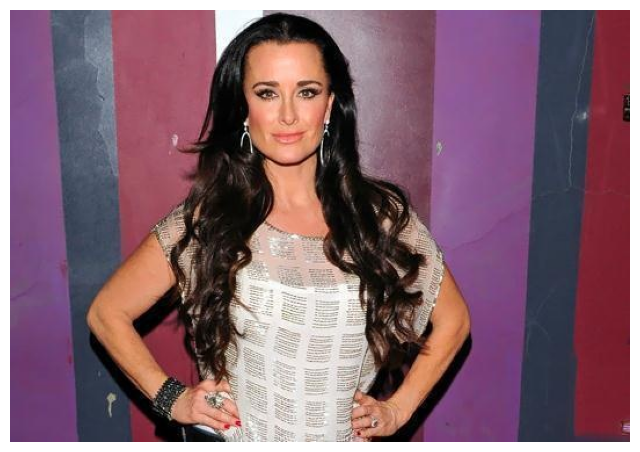

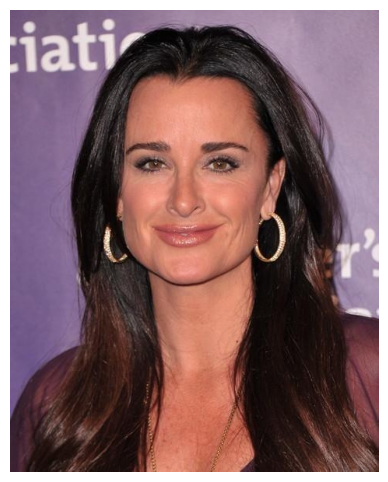

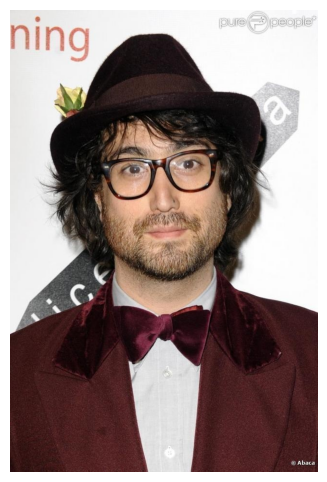

In [11]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('personA_1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

img = cv2.imread('personA_2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

img = cv2.imread('personB_1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()